# Assignment 5.2 - Hyperparameter Optimization

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf. <br><br>
Please do **NOT** rename the file!

#### State both names of your group members here:
[Jane and John Doe]

In [1]:
# Daniel Thompson, Paola Gega

---

## Grading Info/Details - Assignment 5.2:

The assignment will be graded semi-automatically, which means that your code will be tested against a set of predefined test cases and qualitatively assessed by a human. This will speed up the grading process for us.

* For passing the test scripts: 
    - Please make sure to **NOT** alter predefined class or function names, as this would lead to failing of the test scripts.
    - Please do **NOT** rename the files before uploading to the Whiteboard!

* **(RESULT)** tags indicate checkpoints that will be specifically assessed by a human.

* You will pass the assignment if you pass the majority of test cases and we can at least confirm effort regarding the **(RESULT)**-tagged checkpoints per task.

---

## Task 5.2.1 - Brute-Force Hyperparameter Search

* Implement a brute-force search function that finds the best parameter combination for a given model. **(RESULT)**
* Test your implementation on the following problems:
    - 1) A `SVM` model on the two moons problem. **(RESULT)**
    - 2) A `LinearRegression` model with Ridge regularization on the `California Housing Dataset`. **(RESULT)**

Feel free to use `sklearn`'s model implementations.

In [2]:
# You might check for the following hyperparameter ranges:

svm_params = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}


ridge_params = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

In [3]:
# Useful imports
import numpy as np
from sklearn.datasets import make_moons, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import itertools
import matplotlib.pyplot as plt

In [4]:
# Implement a brute-force search
def brute_force_search(model, X, y, search_params):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    keys, values = zip(*search_params.items())
    param_combs = [dict(zip(keys, v)) for v in itertools.product(*values)]
    best_score = -1
    if model=='svc':
        for param in param_combs:
            model = SVC(**param)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            # Calculate accuracy
            score = accuracy_score(y_test, y_pred)
            if score > best_score:
                best_score = score
                best_param = param
    elif model=='ridge':
        for param in param_combs:
            model = Ridge(**param)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            # Calculate MSE
            score = mean_squared_error(y_test, y_pred)
            if best_score == -1: # initialize best_score, best_param first time through the for loop
                best_score = score
                best_param = param
            elif score < best_score:
                best_score = score
                best_param = param
    else:
        raise NotImplementedError(f"Model not implemented: {model}")
    return best_param

Best parameter choices found:
C = 1.0
kernel = rbf
gamma = scale
Accuracy score: 1.0


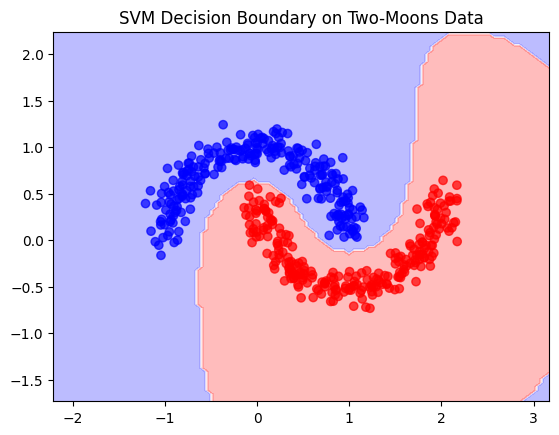

In [5]:
# Generate non-separable synthetic data
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)

svm_best = brute_force_search('svc', X, y, svm_params)
print("Best parameter choices found:")
for key, val in svm_best.items():
    print(key, '=', val)

# Visualize decision boundary for best parameter choice
model = SVC(**svm_best)
model.fit(X, y)
y_pred = model.predict(X)
print("Accuracy score:", accuracy_score(y, y_pred))
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 100),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 100))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title("SVM Decision Boundary on Two-Moons Data")
plt.show()

In [6]:
data = fetch_california_housing()
X = data.data
y = data.target

In [7]:
# print(data.DESCR)

In [8]:
ridge_best = brute_force_search('ridge', X, y, ridge_params)
print("Best parameter choices found:")
for key, val in ridge_best.items():
    print(key, '=', val)

model = Ridge(**ridge_best)
model.fit(X, y)
y_pred = model.predict(X)
print("MSE score:", mean_squared_error(y, y_pred))
print("R^2 score:", r2_score(y, y_pred))

Best parameter choices found:
alpha = 100.0
solver = svd
MSE score: 0.5245925097546553
R^2 score: 0.6060287698313571


**Note:** Our brute-force search gives the same hyperparameter values if we instead try to maximize the $R^2$ score.

## Task 5.2.2 - Simple TPE (BONUS)

* Implement the Tree-Structured Parzen Estimator using `numpy` only. **(RESULT)**
* Find decent hyperparameters for
    - 1) An `SVM` model on the `two moons` problem. **(RESULT)**
    - 2) A `LinearRegression` model with Ridge regularization on the `California Housing Dataset`. **(RESULT)**

In [9]:
'''
Our understanding is that the TPE algorithm only really makes sense when searching
over a large hyperparameter space so we first generate one such for each model.

For simplicity we fix all but one hyperparameter, as this is just a toy example.

Therefore in the sequel, we fix choices as follows because we know the model cannot
fit the data perfectly in these cases.
kernel = sigmoid
gamma = scale

solver = svd
'''

C_params = np.logspace(-3, 3, num=10000)
alpha_params = np.logspace(-3, 3, num=10000)

In [10]:
from sklearn.neighbors import KernelDensity

def TPE(model, X, y, search_space, max_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Start with 100 random evaluation
    np.random.seed(42)
    inds = np.random.choice(1000, 100, replace=False)
    scores = np.empty(100)
    params = search_space[inds]
    for ind in range(100):
        if model=='svc':
            svc = SVC(C = params[ind], kernel = 'sigmoid')
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            # Calculate accuracy
            scores[ind] = accuracy_score(y_test, y_pred)
        elif model=='ridge':
            ridge = Ridge(alpha = params[ind], solver = 'svd')
            ridge.fit(X_train, y_train)
            y_pred = ridge.predict(X_test)
            # Calculate accuracy
            scores[ind] = -mean_squared_error(y_test, y_pred)
        else:
            raise NotImplementedError(f"Model not implemented: {model}")
        
    
    for _ in range(max_iter):
        # Split samples by quantile
        threshold = np.percentile(scores, 20)
        good_params = params[scores >= threshold]
        bad_params = params[scores <= threshold]
        
        # Fit KDEs
        kde_good = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(good_params.reshape(-1, 1))
        kde_bad = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(bad_params.reshape(-1, 1))
        
        # Sample new candidates
        samples = kde_good.sample(100)
        samples = samples[samples>0]
        log_dens_good = kde_good.score_samples(samples.reshape(-1, 1))
        log_dens_bad = kde_bad.score_samples(samples.reshape(-1, 1))
        
        # Compute expected improvement
        ei = np.exp(log_dens_good) / (np.exp(log_dens_bad) + 1e-10)
        
        # Select best candidate
        best_ind = np.argmax(ei)
        best_param = samples[best_ind]
        
        # Evaluate model with best candidate
        if model=='svc':
            svc = SVC(C = best_param, kernel = 'sigmoid')
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            current_score = accuracy_score(y_test, y_pred)
        elif model=='ridge':
            ridge = Ridge(alpha = best_param, solver = 'svd')
            ridge.fit(X_train, y_train)
            y_pred = ridge.predict(X_test)
            current_score = - mean_squared_error(y_test, y_pred)
        else:
            raise NotImplementedError(f"Model not implemented: {model}")
        
        # Update scores
        scores = np.append(scores, current_score)
        params = np.append(params, best_param)
    
    # Return best parameter found
    best_index = np.argmax(scores)
    return params[best_index]

Best parameter choices found:
C = 0.003835821471460335
Accuracy score: 0.782


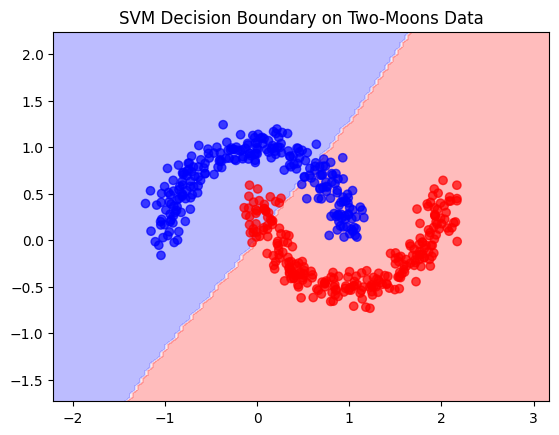

In [11]:
# Generate non-separable synthetic data
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)

val = TPE('svc', X, y, C_params, max_iter=1000)
print("Best parameter choices found:")
print('C =', val)

# Visualize decision boundary for best parameter choice
model = SVC(C = val, kernel = 'sigmoid')
model.fit(X, y)
y_pred = model.predict(X)
print("Accuracy score:", accuracy_score(y, y_pred))
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 100),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 100))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title("SVM Decision Boundary on Two-Moons Data")
plt.show()

**Report:** Our understanding of this outcome is that the sigmoid kernel is a bad way to fit these two moons, and so taking C approaching 0 makes the sigmoid kernel approach linear.

In [12]:
X = data.data
y = data.target

val = TPE('ridge', X, y, alpha_params, max_iter=1000)
print("Best parameter choices found:")
print('alpha =', val)

model = Ridge(alpha = val, solver = 'svd')
model.fit(X, y)
y_pred = model.predict(X)
print("MSE score:", mean_squared_error(y, y_pred))
print("R^2 score:", r2_score(y, y_pred))

Best parameter choices found:
alpha = 1.6035889256798572
MSE score: 0.5243210767944126
R^2 score: 0.6062326171514516


**Report:** This score is better than what we found by our brute force search, though we did expand the parameter search space somewhat so this is not a great surprise.

## Congratz, you made it! :)